In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
import tqdm


###############################################################################

print("sees CUDA device:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)
if torch.cuda.is_available():
    print("GPU in Use:", torch.cuda.get_device_name(0))

###############################################################################



sees CUDA device: True
CUDA Version: 12.4
GPU in Use: NVIDIA L4


In [2]:
def build_mlp(input_dim, n_layers, hidden_units, output_dim):
    """Build an MLP with `n_layers` hidden linear+ReLU layers and a linear output.

    Returns
    -------
    nn.Module
        The constructed MLP.
    """
    layers = []
    # BEGIN YOUR CODE HERE (~5-6 lines)

    for _ in range(n_layers):
        layers += [nn.Linear(input_dim,hidden_units), nn.ReLU()]
        input_dim = hidden_units

    #Y_HAT = nn.Softmax(layers[-1]) I think I need to do this somewhere?  like softmax was in the ssignment
    layers += [nn.Linear(input_dim, output_dim)]


    # END YOUR CODE HERE
    return nn.Sequential(*layers)

def extract_model_params(model):
    """Extract all parameters of a PyTorch model."""
    return torch.cat([p.view(-1) for p in model.parameters() if p.requires_grad])

def load_params_into_model(model, all_params):
    """Loads a flattened array of parameters back into a PyTorch model."""
    current_pos = 0
    for param in model.parameters():
        if param.requires_grad:
            num_params = param.numel()
            # Reshape the flattened parameters to the original shape of the parameter
            param.data.copy_(all_params[current_pos : current_pos + num_params].view(param.size()))
            current_pos += num_params

def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for X, y in loader:
        # BEGIN YOUR CODE HERE (~5-7 lines)


        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()



        # END YOUR CODE HERE
        running_loss += loss.item() * X.size(0)

    # Extract and store the model parameters after the epoch
    all_params = extract_model_params(model)

    return running_loss / len(loader.dataset), all_params.detach().cpu().numpy()


def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in loader:
            # BEGIN YOUR CODE HERE (~4 lines)

            logits = model(X)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)



            # END YOUR CODE HERE

    return correct / total


def compute_loss(model, loader, criterion):
    running_loss = 0.0
    for X, y in loader:
        # BEGIN YOUR CODE HERE (~3 lines)
        with torch.no_grad():
            logits = model(X)
            loss = criterion(logits, y)
            running_loss += loss.item() * X.size(0)

        # END YOUR CODE HERE
    return running_loss / len(loader.dataset)


In [3]:
# Load data (numpy arrays assumed present in workspace)
X_train = np.load("fashion_mnist_train_images.npy").astype(np.float32) / 255.0
y_train = np.load("fashion_mnist_train_labels.npy").astype(np.int64)
X_test = np.load("fashion_mnist_test_images.npy").astype(np.float32) / 255.0
y_test = np.load("fashion_mnist_test_labels.npy").astype(np.int64)

# Flatten if images are HxW
if X_train.ndim == 3:
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

# center data similarly to previous versions
X_train = X_train - 0.5
X_test = X_test - 0.5

# Convert to tensors
X_train_t = torch.from_numpy(X_train)
y_train_t = torch.from_numpy(y_train)
X_test_t = torch.from_numpy(X_test)
y_test_t = torch.from_numpy(y_test)

# SEED FIX
torch.manual_seed(541)
np.random.seed(541)

# Train/val split
full_train = TensorDataset(X_train_t, y_train_t)
val_size = int(0.2 * len(full_train))
train_size = len(full_train) - val_size
train_dataset, val_dataset = random_split(full_train, [train_size, val_size])


In [4]:
def hyperparam_tuning(train_dataset, val_dataset, seed=541):
    """Systematically search hyperparameters and return the best config and model state.

    Returns
    -------
    dict, state_dict
        Best hyperparameters and the corresponding model state dict.
    """
    torch.manual_seed(seed)
    np.random.seed(seed)

    best_cfg = None
    best_acc = 0.0
    # BEGIN YOUR CODE HERE (~15-20 lines)


    batch_sizes = [8,12,16,20,32,48,64,128,145,256]
    learning_rates= [0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001]
    layers = [2,3,4,5,6]
    hidden = [5,10,20,30,40]
    alphas = [0,0.0005,0.001,0.0001,0.00001]
    epochs = [15, 20, 25]


    #########################################
    x0, y0 = train_dataset[0]
    n_features = x0.numel()
    n_classes  = 10
    ##############################################3


    loopcount = 0

    config_attempts = 50



    for _ in range(config_attempts):


        layer_choice =  int(np.random.choice(layers).item())
        batch_size_choice = int(np.random.choice(batch_sizes).item())
        learning_rate_choice =float(np.random.choice(learning_rates).item())
        hidden_choice = int(np.random.choice(hidden).item())
        aplha_choice = float(np.random.choice(alphas).item())
        epoch_choices = int(np.random.choice(epochs).item())

        train_loader = DataLoader(train_dataset, batch_size=batch_size_choice, shuffle=True)
        val_loader   = DataLoader(val_dataset,   batch_size=batch_size_choice, shuffle=False)

        # SEED FIX
        torch.manual_seed(seed + loopcount)
        model = build_mlp(n_features, layer_choice,hidden_choice, n_classes)
        criterion = nn.CrossEntropyLoss()

        ############################################################################# needs revision


        weight_params =[]
        bias_params = []
        for name, p in model.named_parameters():
            (weight_params if 'weight' in name else bias_params).append(p)
        optimizer = torch.optim.SGD([{'params': weight_params, 'weight_decay': aplha_choice},{'params': bias_params,   'weight_decay': 0.0}],lr=learning_rate_choice)




        ################################################################################

        for _e in range(epoch_choices):
            train_epoch(model, train_loader, criterion, optimizer)

        current_accuracy = evaluate(model, val_loader)

        # sanity check to see what loop im on and to ensure its not like frozen
        loopcount = loopcount +1
        #print("on loop ", loopcount)# turned off for final output

        if current_accuracy > best_acc:
            best_acc = current_accuracy
            print("best accuracy ",best_acc)
            #best_configs = [layer_choice , batch_size_choice , learning_rate_choice, hidden_choice , aplha_choice , epoch_choices]

            best_cfg = {
                    "layers": layer_choice,
                    "hidden": hidden_choice,
                    "batch": batch_size_choice,
                    "learning_rate": learning_rate_choice,
                    "alpha": aplha_choice,
                    "epochs": epoch_choices,
                    "seed": seed + loopcount - 1  # SEED FIX
                }

            print("New best:", best_cfg, "val_acc=", f"{best_acc:.4f}")



    # END YOUR CODE HERE

    return best_cfg, best_acc


# Run hyperparameter tuning
best_cfg, best_acc = hyperparam_tuning(train_dataset, val_dataset)
print(f"Best config: {best_cfg} with val_acc={best_acc:.4f}")



best accuracy  0.2663333333333333
New best: {'layers': 2, 'hidden': 5, 'batch': 20, 'learning_rate': 0.0001, 'alpha': 1e-05, 'epochs': 20, 'seed': 541} val_acc= 0.2663
best accuracy  0.2911666666666667
New best: {'layers': 6, 'hidden': 5, 'batch': 20, 'learning_rate': 0.001, 'alpha': 0.0005, 'epochs': 25, 'seed': 544} val_acc= 0.2912
best accuracy  0.85925
New best: {'layers': 4, 'hidden': 40, 'batch': 8, 'learning_rate': 0.001, 'alpha': 0.0001, 'epochs': 25, 'seed': 548} val_acc= 0.8592
best accuracy  0.8629166666666667
New best: {'layers': 4, 'hidden': 20, 'batch': 16, 'learning_rate': 0.005, 'alpha': 0.0005, 'epochs': 25, 'seed': 564} val_acc= 0.8629
best accuracy  0.87725
New best: {'layers': 3, 'hidden': 40, 'batch': 16, 'learning_rate': 0.01, 'alpha': 0.001, 'epochs': 25, 'seed': 576} val_acc= 0.8772
Best config: {'layers': 3, 'hidden': 40, 'batch': 16, 'learning_rate': 0.01, 'alpha': 0.001, 'epochs': 25, 'seed': 576} with val_acc=0.8772


In [5]:
# Retrain best model on full training set (train+val) for more epochs
n_features = X_train.shape[1]
n_classes = int(y_train.max() + 1)
# Instantiate the best model
# BEGIN YOUR CODE HERE (~3 lines)


torch.manual_seed(best_cfg['seed']) # SEED FIX
best_model = build_mlp(
    n_features,
    best_cfg['layers'],
    best_cfg['hidden'],
    n_classes
)



# END YOUR CODE HERE

# create full training loader and test loader
batch_size = best_cfg['batch']
full_train_loader = DataLoader(full_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=batch_size, shuffle=False)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(best_model.parameters(),
                          lr=best_cfg['learning_rate'],
                          weight_decay=best_cfg['alpha'])
# retrain best model
epochs_final = 50
parameter_history = []
for epoch in range(epochs_final):
    # BEGIN YOUR CODE HERE (~2 lines)

    t0 = __import__('time').time(); loss, flat_params = train_epoch(best_model, full_train_loader, criterion, optimizer)
    parameter_history.append(flat_params); test_acc = evaluate(best_model, test_loader); t1 = __import__('time').time()


    # END YOUR CODE HERE
    print(f"Final Train Epoch {epoch+1}/{epochs_final}: loss={loss:.4f}, test_acc={test_acc:.4f}, time={t1-t0:.1f}s")

# Print the length of the parameter_history list
print(f"Length of parameter history: {len(parameter_history)}")
print(f"Final Test Accuracy: {test_acc:.4f}")



Final Train Epoch 1/50: loss=1.0717, test_acc=0.7680, time=4.7s
Final Train Epoch 2/50: loss=0.5385, test_acc=0.8125, time=4.8s
Final Train Epoch 3/50: loss=0.4607, test_acc=0.8287, time=4.8s
Final Train Epoch 4/50: loss=0.4252, test_acc=0.8376, time=4.8s
Final Train Epoch 5/50: loss=0.4013, test_acc=0.8472, time=4.8s
Final Train Epoch 6/50: loss=0.3842, test_acc=0.8484, time=4.8s
Final Train Epoch 7/50: loss=0.3693, test_acc=0.8541, time=4.7s
Final Train Epoch 8/50: loss=0.3564, test_acc=0.8619, time=4.7s
Final Train Epoch 9/50: loss=0.3480, test_acc=0.8578, time=4.7s
Final Train Epoch 10/50: loss=0.3390, test_acc=0.8604, time=4.7s
Final Train Epoch 11/50: loss=0.3320, test_acc=0.8555, time=4.7s
Final Train Epoch 12/50: loss=0.3253, test_acc=0.8678, time=4.7s
Final Train Epoch 13/50: loss=0.3207, test_acc=0.8588, time=4.7s
Final Train Epoch 14/50: loss=0.3159, test_acc=0.8644, time=4.6s
Final Train Epoch 15/50: loss=0.3112, test_acc=0.8685, time=4.8s
Final Train Epoch 16/50: loss=0.30

In [6]:
def build_enhanced_mlp(input_dim, n_layers, hidden_units, output_dim,
                       use_batchnorm=False, dropout_rate=0.0, activation='relu'):
    """Build enhanced MLP with optional BatchNorm, Dropout, and different activations."""
    layers = []

    activations = {
        'relu': nn.ReLU(),
        'leaky': nn.LeakyReLU(0.01),
        'elu': nn.ELU(),
        'prelu': nn.PReLU()
    }
    act_fn = activations[activation]

    for i in range(n_layers):
        layers.append(nn.Linear(input_dim, hidden_units))

        if use_batchnorm:
            layers.append(nn.BatchNorm1d(hidden_units))

        layers.append(act_fn if activation != 'prelu' else nn.PReLU())

        if dropout_rate > 0:
            layers.append(nn.Dropout(dropout_rate))

        input_dim = hidden_units

    layers.append(nn.Linear(input_dim, output_dim))

    return nn.Sequential(*layers)


def enhanced_hyperparam_tuning(train_dataset, val_dataset, seed=541):
    """Find best enhanced architecture config."""
    torch.manual_seed(seed)
    np.random.seed(seed)

    best_cfg = None
    best_acc = 0.0

    batch_sizes = [32, 64, 128]
    learning_rates = [0.001, 0.0005, 0.0001]
    layers = [3, 4, 5]
    hidden = [64, 128, 256]
    alphas = [0, 0.0001, 0.00001]
    epochs = [30, 40]

    use_batchnorm_options = [True, False]
    dropout_rates = [0.0, 0.2, 0.3, 0.5]
    activations = ['relu', 'leaky', 'elu', 'prelu']

    x0, y0 = train_dataset[0]
    n_features = x0.numel()
    n_classes = 10

    loopcount = 0
    config_attempts = 15

    for _ in range(config_attempts):

        layer_choice = int(np.random.choice(layers))
        batch_size_choice = int(np.random.choice(batch_sizes))
        learning_rate_choice = float(np.random.choice(learning_rates))
        hidden_choice = int(np.random.choice(hidden))
        alpha_choice = float(np.random.choice(alphas))
        epoch_choice = int(np.random.choice(epochs))
        use_bn = bool(np.random.choice(use_batchnorm_options))
        dropout = float(np.random.choice(dropout_rates))
        activation = np.random.choice(activations)

        train_loader = DataLoader(train_dataset, batch_size=batch_size_choice, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size_choice, shuffle=False)

        torch.manual_seed(seed + loopcount) # SEED FIX
        model = build_enhanced_mlp(n_features, layer_choice, hidden_choice, n_classes,
                                  use_batchnorm=use_bn, dropout_rate=dropout, activation=activation)

        weight_params = []
        bias_params = []
        for name, p in model.named_parameters():
            (weight_params if 'weight' in name else bias_params).append(p)

        optimizer = torch.optim.SGD([
            {'params': weight_params, 'weight_decay': alpha_choice},
            {'params': bias_params, 'weight_decay': 0.0}
        ], lr=learning_rate_choice)

        criterion = nn.CrossEntropyLoss()

        for _e in range(epoch_choice):
            train_epoch(model, train_loader, criterion, optimizer)

        current_accuracy = evaluate(model, val_loader)

        loopcount = loopcount + 1
        #print("on enhanced loop ", loopcount)

        if current_accuracy > best_acc:
            best_acc = current_accuracy
            print("best enhanced accuracy ", best_acc)

            best_cfg = {
                "layers": layer_choice,
                "hidden": hidden_choice,
                "batch": batch_size_choice,
                "learning_rate": learning_rate_choice,
                "alpha": alpha_choice,
                "epochs": epoch_choice,
                "batchnorm": use_bn,
                "dropout": dropout,
                "activation": activation,
                "seed": seed + loopcount - 1  # SEED FIX
            }

            print("New best enhanced:", best_cfg, "val_acc=", f"{best_acc:.4f}")

    return best_cfg, best_acc


enhanced_cfg, enhanced_acc = enhanced_hyperparam_tuning(train_dataset, val_dataset)
print(f"Enhanced config: {enhanced_cfg} with val_acc={enhanced_acc:.4f}")

# Train final enhanced model
torch.manual_seed(enhanced_cfg['seed']) # SEED FIX
enhanced_model = build_enhanced_mlp(
    n_features,
    enhanced_cfg['layers'],
    enhanced_cfg['hidden'],
    n_classes,
    use_batchnorm=enhanced_cfg['batchnorm'],
    dropout_rate=enhanced_cfg['dropout'],
    activation=enhanced_cfg['activation']
)

batch_size = enhanced_cfg['batch']
full_train_loader = DataLoader(full_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=batch_size, shuffle=False)
criterion = nn.CrossEntropyLoss()

weight_params = []
bias_params = []
for name, p in enhanced_model.named_parameters():
    (weight_params if 'weight' in name else bias_params).append(p)

optimizer = torch.optim.SGD([
    {'params': weight_params, 'weight_decay': enhanced_cfg['alpha']},
    {'params': bias_params, 'weight_decay': 0.0}
], lr=enhanced_cfg['learning_rate'])

# retrain enhanced model
epochs_final = 50
for epoch in range(epochs_final):
    t0 = __import__('time').time(); loss, _ = train_epoch(enhanced_model, full_train_loader, criterion, optimizer)
    test_acc = evaluate(enhanced_model, test_loader); t1 = __import__('time').time()
    print(f"Enhanced Train Epoch {epoch+1}/{epochs_final}: loss={loss:.4f}, test_acc={test_acc:.4f}, time={t1-t0:.1f}s")

print(f"Final Enhanced Test Accuracy: {test_acc:.4f}")


best enhanced accuracy  0.7305833333333334
New best enhanced: {'layers': 5, 'hidden': 64, 'batch': 32, 'learning_rate': 0.001, 'alpha': 0.0001, 'epochs': 30, 'batchnorm': False, 'dropout': 0.0, 'activation': np.str_('relu'), 'seed': 541} val_acc= 0.7306
best enhanced accuracy  0.8628333333333333
New best enhanced: {'layers': 4, 'hidden': 64, 'batch': 64, 'learning_rate': 0.001, 'alpha': 0.0, 'epochs': 30, 'batchnorm': True, 'dropout': 0.2, 'activation': np.str_('leaky'), 'seed': 542} val_acc= 0.8628
best enhanced accuracy  0.8870833333333333
New best enhanced: {'layers': 4, 'hidden': 256, 'batch': 32, 'learning_rate': 0.001, 'alpha': 0.0001, 'epochs': 30, 'batchnorm': True, 'dropout': 0.2, 'activation': np.str_('relu'), 'seed': 546} val_acc= 0.8871
Enhanced config: {'layers': 4, 'hidden': 256, 'batch': 32, 'learning_rate': 0.001, 'alpha': 0.0001, 'epochs': 30, 'batchnorm': True, 'dropout': 0.2, 'activation': np.str_('relu'), 'seed': 546} with val_acc=0.8871
Enhanced Train Epoch 1/50: l

100%|██████████| 25/25 [00:18<00:00,  1.37it/s]


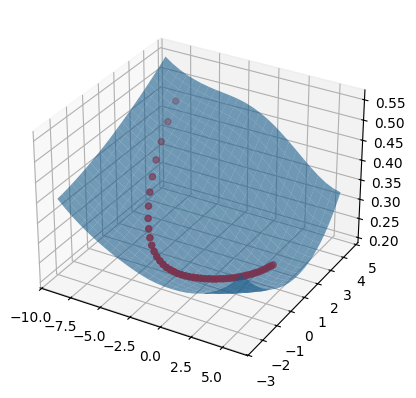

In [7]:
def plotPath(loader, trajectory, model):
    # TODO: change this toy plot to show a 2-d projection of the weight space
    # along with the associated loss (cross-entropy), plus a superimposed
    # trajectory across the landscape that was traversed using SGD. Use
    # sklearn.decomposition.PCA's fit_transform and inverse_transform methods.

    from sklearn.decomposition import PCA

    # Setup PCA and subset loader for efficient computation
    trajectory_array = np.array(trajectory)
    pca = PCA(n_components=2)
    trajectory_2d = pca.fit_transform(trajectory_array)

    # Create subset of training data (2500 examples) as suggested
    subset_indices = np.random.choice(len(loader.dataset), min(2500, len(loader.dataset)), replace=False)
    subset_loader = DataLoader(torch.utils.data.Subset(loader.dataset, subset_indices), batch_size=256)
    criterion = nn.CrossEntropyLoss()

    def lossFunction(x1, x2):
        point_params = pca.inverse_transform(np.array([[x1, x2]]))[0]
        load_params_into_model(model, torch.from_numpy(point_params).float())
        return compute_loss(model, subset_loader, criterion)

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # Compute the CE loss on a grid of points (corresonding to different w).
    x_min, x_max = trajectory_2d[:, 0].min(), trajectory_2d[:, 0].max()
    y_min, y_max = trajectory_2d[:, 1].min(), trajectory_2d[:, 1].max()
    x_margin = 0.2 * (x_max - x_min)
    y_margin = 0.2 * (y_max - y_min)
    axis1 = np.linspace(x_min - x_margin, x_max + x_margin, 25) #have to cap this at 25 or i get an error
    axis2 = np.linspace(y_min - y_margin, y_max + y_margin, 25)
    Xaxis, Yaxis = np.meshgrid(axis1, axis2)
    Zaxis = np.zeros((25, 25))
    for i in tqdm.tqdm(range(25)):
        for j in range(25):
            Zaxis[i,j] = lossFunction(Xaxis[i,j], Yaxis[i,j])
    ax.plot_surface(Xaxis, Yaxis, Zaxis, alpha=0.6)

    # Now superimpose a scatter plot showing the weights during SGD.
    Xaxis = trajectory_2d[:, 0]
    Yaxis = trajectory_2d[:, 1]
    Zaxis = np.array([lossFunction(x, y) for x, y in zip(Xaxis, Yaxis)])
    ax.scatter(Xaxis, Yaxis, Zaxis, color='r')

    plt.show()

# Problem 3: Visualizing the loss landscape and optimization trajectories
# Plot the trajectory of parameters during training
# Uncomment to run
plotPath(full_train_loader, parameter_history, best_model)